In [30]:
%matplotlib notebook
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import glob

import MosaicFitsReader as mfr
import FindSources as fs

In [31]:
 def centroid(arr):
    """
    One step 1D centroiding algo.
    Returns centroid position and standard deviation
    """
    l = arr.shape[0]
    ixs = np.arange(l)
    arr = arr - np.median(arr)
    arr = np.where(arr < 0, 0, arr)    
    ixs2 = ixs * ixs
    sumarr = arr.sum()
    cen = np.dot(arr, ixs)/sumarr
    return cen, math.sqrt(np.dot(arr, ixs2)/sumarr - cen * cen)

def centroidLoop(arr, fromIdx, toIdx, nLoops=10, epsilon=1E-1):
    """
    Finds the centroid by repeatedly centering and recalculating 
    until the centroid position changes by less than epsilon.
    
    Returns status, centroid position, standard deviation, iterations
    
    status: 0 OK, -1 bad centroid or no signal
    centroid position: position relative to input array, ie. 0 is first pixel
    standard deviation: standard deviation as calculated by the centroid algorithm (assumed Gaussian stats)
    iterations: number of iterations needed until change is less than epsilon
    """
    def limit(x):
        if x < 0: return 0
        if x >= length: return length
        return x
    
    length = len(arr)
    radius = (toIdx - fromIdx)/2
    lastCenPos = -9999
    for i in range(nLoops):
        fromIdx = int(limit(fromIdx))
        toIdx = int(limit(fromIdx + radius + radius + 0.5))
        pos, cenStd = centroid(arr[fromIdx:toIdx])
        cenPos = pos + fromIdx
        #print (i, fromIdx, toIdx, cenPos, cenStd, lastCenPos)
        
        if cenPos < fromIdx or toIdx < cenPos:
            return -1, 0, 0, i
        
        if abs(lastCenPos - cenPos) < epsilon:
            return 0, cenPos, cenStd, i
        if cenStd > radius/3:
            return -1, cenPos, cenStd, i
        fromIdx = cenPos - radius
        lastCenPos = cenPos
        
    return -1, cenPos, cenStd, i  

In [32]:
def findWidths (arr1d, size=60):
    """
    Divides the input array in segments of size length.
    For each segment, finds the centroid, if centroid is good then record it.
    Sorts the centroids by standard deviation.
    Returns the smallest half of the standard deviation
    """
    out = []
    for x in range(0, len(arr1d)-size, size):
        ok, cen, std, idx = centroidLoop(arr1d, x, x+size)     
        #print (res)
        if ok == 0:
            out.append((std, cen))
    #print (out)
    if len(out) <= 0:
        return []
    out = sorted(out, key=lambda x: x[0])
    return out[:len(out)//2]

def findFWHMs (img, gridSize=90):
    fc = fs.FindSources(img, minContrast=0)
    cents = fc.findAll(gridSize, 0.8)
    cents = [x for x in cents if x[2] < 10] #x[2] is fwhm
    return cents

In [33]:
def measureFocusWidthSpec (prefix, fromNr, toNr, focusKeyword='BLUFOCUS', column=1700, segmSize=60):
    """
    For all input files, finds the standard deviations of the centroids.
    These standard deviations are assosicated with the focus. 

    Output is stored in out[].
    """

    out = []
    for fnr in range(fromNr, toNr):
        fname = "%s%04d.fits" % (prefix, fnr)
        ffile = mfr.MosaicFitsReader(fname)
        img = ffile.data
        focus = ffile.getKeyword(focusKeyword)
        if focus == None:
            continue
        cut1d = img[:,column]
        widths = findWidths(cut1d, segmSize)
        widthsT = np.array(widths).T
        out.extend(( (focus,x) for x in widthsT[0] ))
    return np.array(out).T

def measureFocusWidthImg (prefix, fromNr, toNr, focusKeyword='BLUFOCUS', gridSize=90):
    """
    For all input files, finds the standard deviations of the centroids.
    These standard deviations are assosicated with the focus. 

    Output is stored in out[].
    """

    out = []
    for fnr in range(fromNr, toNr):
        fname = "%s%04d.fits" % (prefix, fnr)
        ffile = mfr.MosaicFitsReader(fname)
        img = ffile.data
        focus = ffile.getKeyword(focusKeyword)
        if focus == None:
            continue
        cents = findFWHMs(img, gridSize)
        centsT = np.array(cents).T
        out.extend(( (focus,x) for x in centsT[2] ))
    return np.array(out).T

In [34]:
def plotWidthVsFocus (pairs, minX, f2wFunc):
    """
    Plots the (focus, std) pairs
    """
    plt.figure()
    plt.grid()
    plt.plot(pairs[0], pairs[1], 'o')

    x0, x1 = min(pairs[0]), max(pairs[0])
    dx = (x1 - x0)/2
    x0, x1 = x0-dx, x1+dx

    """
    Plots the fitted hyperbola
    """
    xs = np.linspace(x0, x1, 100)
    plt.plot(xs, f2wFunc(xs))

    """
    Plots a vertical line at best focus and a horizontal line at best focus
    """
    plt.plot((x0, x1), (f2wFunc(minX), f2wFunc(minX)), 'k:')
    plt.plot((minX, minX), (min(pairs[1]), max(pairs[1])), 'k:')


In [35]:
def findBestFocus(pairs):
    """
    Fits a hyperbola: x=focus, y=standard deviation

    Hyperbola equation: y^2 = Ax^2 + Bx + C

    """
    res = np.polyfit(pairs[0], np.multiply(pairs[1], pairs[1]), deg=2)

    func = np.poly1d(res)
    def func1 (x):
        return math.sqrt(func(x))

    funcV = np.vectorize(func1)
    A, B, C = res
    minX = -B/2/A
    return minX, funcV

## Imaging - best focus

<IPython.core.display.Javascript object>


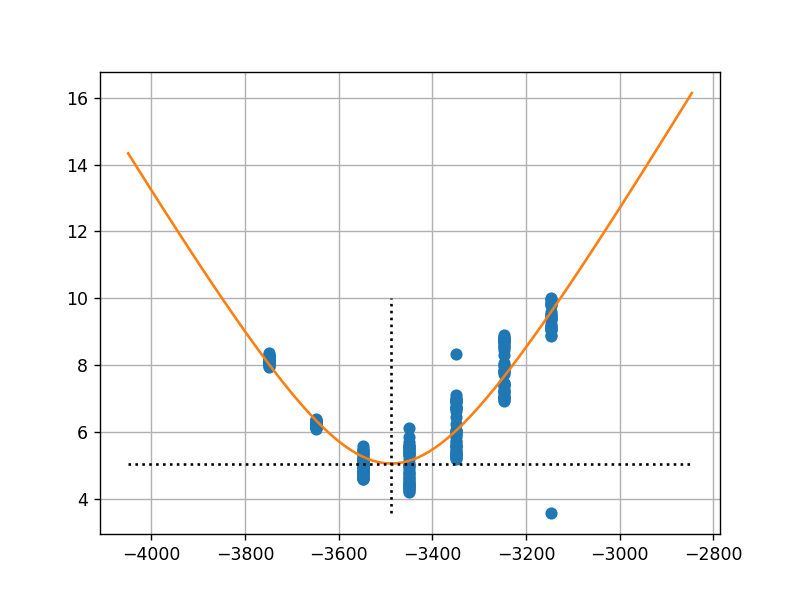

In [36]:
pairs = measureFocusWidthImg('im_bfoc', 5, 12, 'BLUFOCUS', gridSize=90)
minX, funcV = findBestFocus(pairs)

plotWidthVsFocus(pairs, minX, f2wFunc=funcV)

## Blue Spectroscopy - best focus

<IPython.core.display.Javascript object>


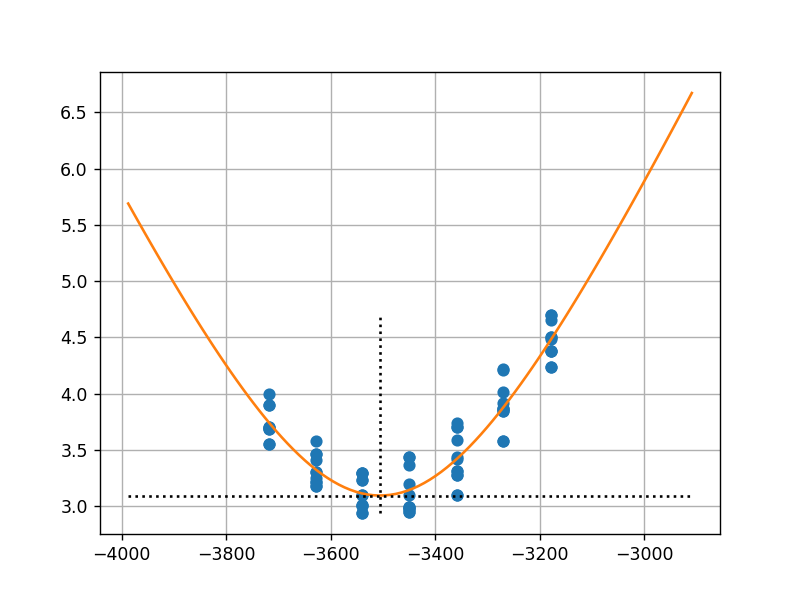

In [37]:
bpairs = measureFocusWidthSpec('bfoc', 8, 15, 'BLUFOCUS', segmSize=60, column=1700)
bminX, bfuncV = findBestFocus(bpairs)

plotWidthVsFocus(bpairs, bminX, f2wFunc=bfuncV)

## Red Spectroscopy - best focus

<IPython.core.display.Javascript object>


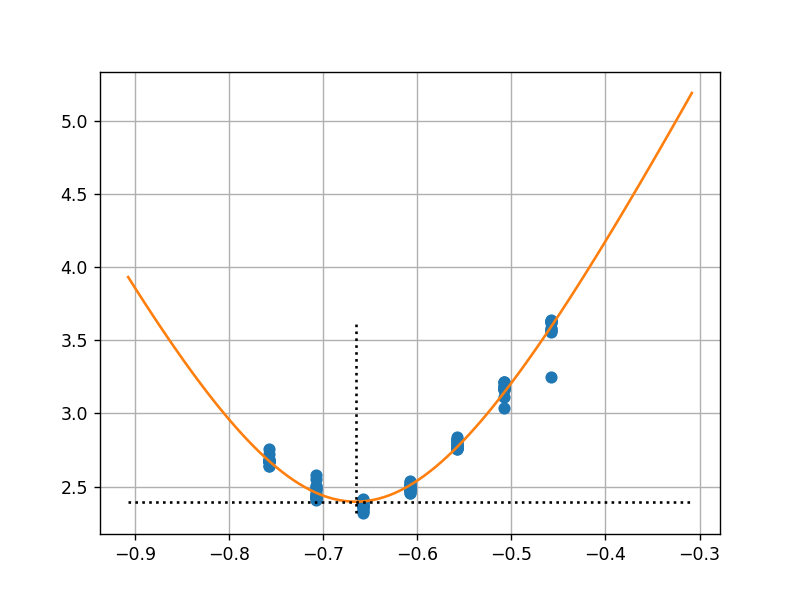

In [29]:
rpairs = measureFocusWidthSpec('rfoc', 1, 8, 'REDFOCUS', segmSize=40, column=1700)
rminX, rfuncV = findBestFocus(rpairs)

plotWidthVsFocus(rpairs, rminX, f2wFunc=rfuncV)